In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm

from tqdm.auto import tqdm as tqdm_auto
from tqdm.notebook import tqdm

import Bio.SeqIO

In [2]:
# Loading values
drna = pd.read_csv("../../data/stability/raw/RNA_raw_counts_05_28_20.tsv", sep="\t", header=0)

# Loading sequences
sequence_fasta = list(Bio.SeqIO.parse("../../data/stability/raw/library_order_05_06_19_selected_sequences.fa", "fasta"))
assert len(set(rec.name for rec in sequence_fasta)) == len(sequence_fasta), "Duplicates found"
seqs = {rec.name: rec.seq.__str__().upper() for rec in sequence_fasta}

# Mapping
drna.insert(0, "seq", drna["seq_id"].map(seqs))

In [3]:
# Loading values
ddna = pd.read_csv("../../data/stability/raw/DNA_raw_counts_05_28_20.tsv", sep="\t", header=0)

# Mapping
ddna.insert(0, "seq", ddna["seq_id"].map(seqs))

In [4]:
import re

meta_cols = {"seq", "seq_id"}

def rename_col_names(col_name, mode):
    if col_name in meta_cols:
        return ("meta", col_name)
    replicate, bin_ = re.match(r"(\d+)_(\d+)", col_name).group(1, 2)
    return "data", (mode, replicate, bin_)

In [5]:
drna.columns = pd.MultiIndex.from_tuples([rename_col_names(i, mode="RNA") for i in drna.columns])
drna_meta = drna["meta"].copy()
drna = drna["data"].copy()
drna.columns = pd.MultiIndex.from_tuples(drna.columns, names=["exp_type", "replicate", "bin"])
drna.sort_index(axis=1, inplace=True)
drna.index = drna_meta["seq"]
drna = drna.astype("Int32")

In [6]:
ddna.columns = pd.MultiIndex.from_tuples([rename_col_names(i, mode="gDNA") for i in ddna.columns])
ddna_meta = ddna["meta"].copy()
ddna = ddna["data"].copy()
ddna.columns = pd.MultiIndex.from_tuples(ddna.columns, names=["exp_type", "replicate", "bin"])
ddna.sort_index(axis=1, inplace=True)
ddna.index = ddna_meta["seq"]
ddna = ddna.astype("Int32")

In [7]:
assert (drna.index == ddna.index).all(), "Index discrepancy"

In [8]:
d1 = pd.concat([drna, ddna], axis=1)

### Loading fits

In [9]:
fits_RNA = pd.read_csv("fit_results_stability_RNA.csv")
fits_gDNA = pd.read_csv("fit_results_stability_gDNA.csv")
fits = pd.concat([fits_RNA, fits_gDNA])
fits.head()

,exp_type,replicate,bin,wd1,wd2,psi,p1,n1,p2,n2
0,RNA,1,1,0.010243,0.989757,0.993738,0.803897,9.991563,0.004078,1.351701
1,RNA,1,2,0.032172,0.967828,0.997962,0.046886,0.745054,0.005425,1.658112
2,RNA,1,3,0.108784,0.891216,0.993811,0.026755,0.865248,0.005409,1.945892
3,RNA,1,4,0.123668,0.876332,0.994572,0.018632,1.013498,0.005866,2.603409
4,RNA,1,5,0.175888,0.824112,0.996379,0.008727,0.765900,0.005042,2.759482


The distribution should be the most 'typical' one.

Let's assume that the most 'typical' distribution is the one with the closest to average read count value.

In [10]:
ref_type = "RNA"
d1_RNA = d1.xs(ref_type, level=0, axis=1)
ref_rep, ref_bin = d1_RNA.columns[np.abs(d1_RNA.mean(axis=0) - d1_RNA.mean(axis=None)).argmin()]
reference_fit_id_RNA = (ref_type, int(ref_rep), int(ref_bin))
reference_fit_id_RNA

('RNA', 1, 3)

In [11]:
ref_type = "gDNA"
d1_gDNA = d1.xs(ref_type, level=0, axis=1)
ref_rep, ref_bin = d1_gDNA.columns[np.abs(d1_gDNA.mean(axis=0) - d1_gDNA.mean(axis=None)).argmin()]
reference_fit_id_gDNA = (ref_type, int(ref_rep), int(ref_bin))
reference_fit_id_gDNA

('gDNA', 2, 8)

In [12]:
reference_fit_params_RNA = fits.set_index(["exp_type", "replicate", "bin"]).loc[reference_fit_id_RNA].to_dict()
reference_fit_params_gDNA = fits.set_index(["exp_type", "replicate", "bin"]).loc[reference_fit_id_gDNA].to_dict()

In [13]:
reference_fit_params_gDNA

{'wd1': 0.058236088888688,
 'wd2': 0.941763911111312,
 'psi': 0.993610007189764,
 'p1': 0.0512552284500677,
 'n1': 1.179497730371332,
 'p2': 0.0007731803594247,
 'n2': 1.7228863881342789}

In [14]:
def get_reference_rv(wd1, wd2, psi, p1, n1, p2, n2):
    wd_est = np.array([wd1, wd2])
    mixture_dist = pm.Mixture.dist(
        w=wd_est,
        comp_dists=[
            pm.ZeroInflatedNegativeBinomial.dist(psi=psi, p=p1, n=n1),
            pm.ZeroInflatedNegativeBinomial.dist(psi=psi, p=p2, n=n2),
        ])
    return mixture_dist

In [15]:
reference_rv_dict = {
    "RNA": get_reference_rv(**reference_fit_params_RNA),
    "gDNA": get_reference_rv(**reference_fit_params_gDNA),
}

Checking the maximal theoretical value (it's unlikely that we are going to exceed it)

In [16]:
max_theoretical_value = d1.max(axis=None)
max_theoretical_value

203675

In [17]:
from scipy.spatial import KDTree


def get_discrete_icdf(rv, min_value=0, max_value=100_000):
    if min_value != 0:
        raise NotImplementedError
    logcdf = pm.logcdf(rv, np.arange(0, max_value + 1)).eval()
    cdf = np.exp(logcdf)
    round_tree = KDTree(cdf[:, np.newaxis], leafsize=10)

    def icdf(q: np.array):
        q = np.asarray(q)
        norm_vals = round_tree.query(q[:, np.newaxis], k=1)[1]
        # indices returned by the query are in fact the RV values as well
        return norm_vals

    return icdf

In [18]:
d1_normalized = d1.copy()

for (exp_type, replicate_id), fits_grp in tqdm(fits.groupby(by=["exp_type", "replicate"])):
    # if exp_type == "RNA":
    #     continue
    for i, lib_fit in fits_grp.iterrows():
        # Fitting library
        lib_key = (lib_fit["exp_type"], str(lib_fit["replicate"]), str(lib_fit["bin"]))
        lib = d1[lib_key].values
        libmax = lib.max()
        lib_fit_params = lib_fit.iloc[3:].to_dict()

        # Calculating CDF
        lib_rv = get_reference_rv(**lib_fit_params)
        lib_logcdf = logcdf = pm.logcdf(lib_rv, np.arange(0, libmax + 1)).eval()
        lib_cdf = np.exp(lib_logcdf)
        lib_q = lib_cdf[lib.astype(np.int32)]  # Since library starts at 0, cdf array is the inverse quantile function

        # Calculating quantiles
        reference_icdf_func = get_discrete_icdf(reference_rv_dict[lib_fit["exp_type"]], max_value=max_theoretical_value)
        lib_norm = reference_icdf_func(lib_q)

        # Normalizing CPMs
        # # Notice the pseudocount
        # lib_norm = lib_norm + 1
        # lib_norm_cpm = lib_norm / lib_norm.sum() * 1_000_000
        d1_normalized[lib_key] = lib_norm

  0%|          | 0/4 [00:00<?, ?it/s]

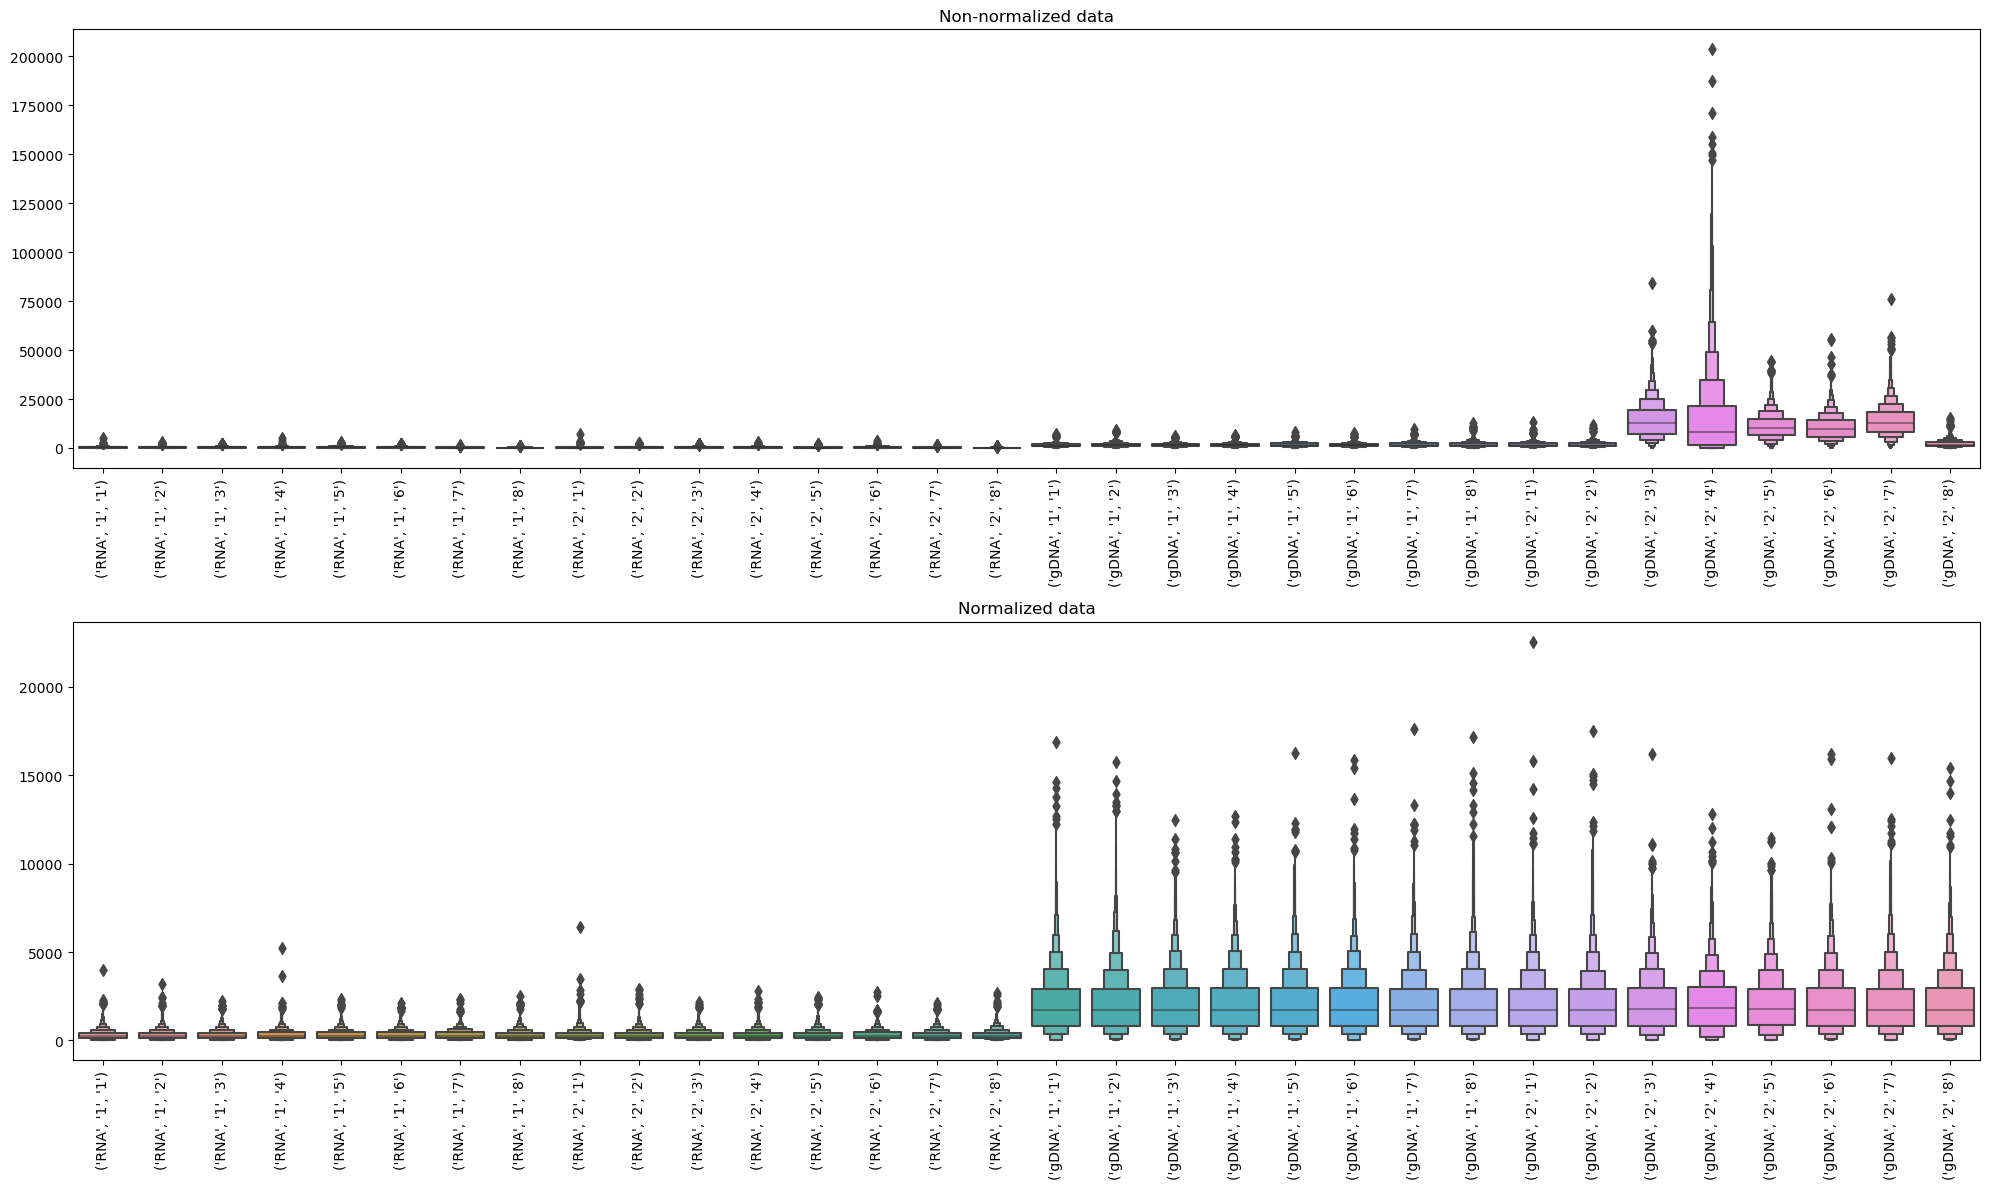

In [19]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 1, 1)
sns.boxenplot(d1)
plt.xticks(rotation=90)
plt.title("Non-normalized data")

plt.subplot(2, 1, 2)
sns.boxenplot(d1_normalized)
plt.xticks(rotation=90)
plt.title("Normalized data")

plt.tight_layout()
plt.show()

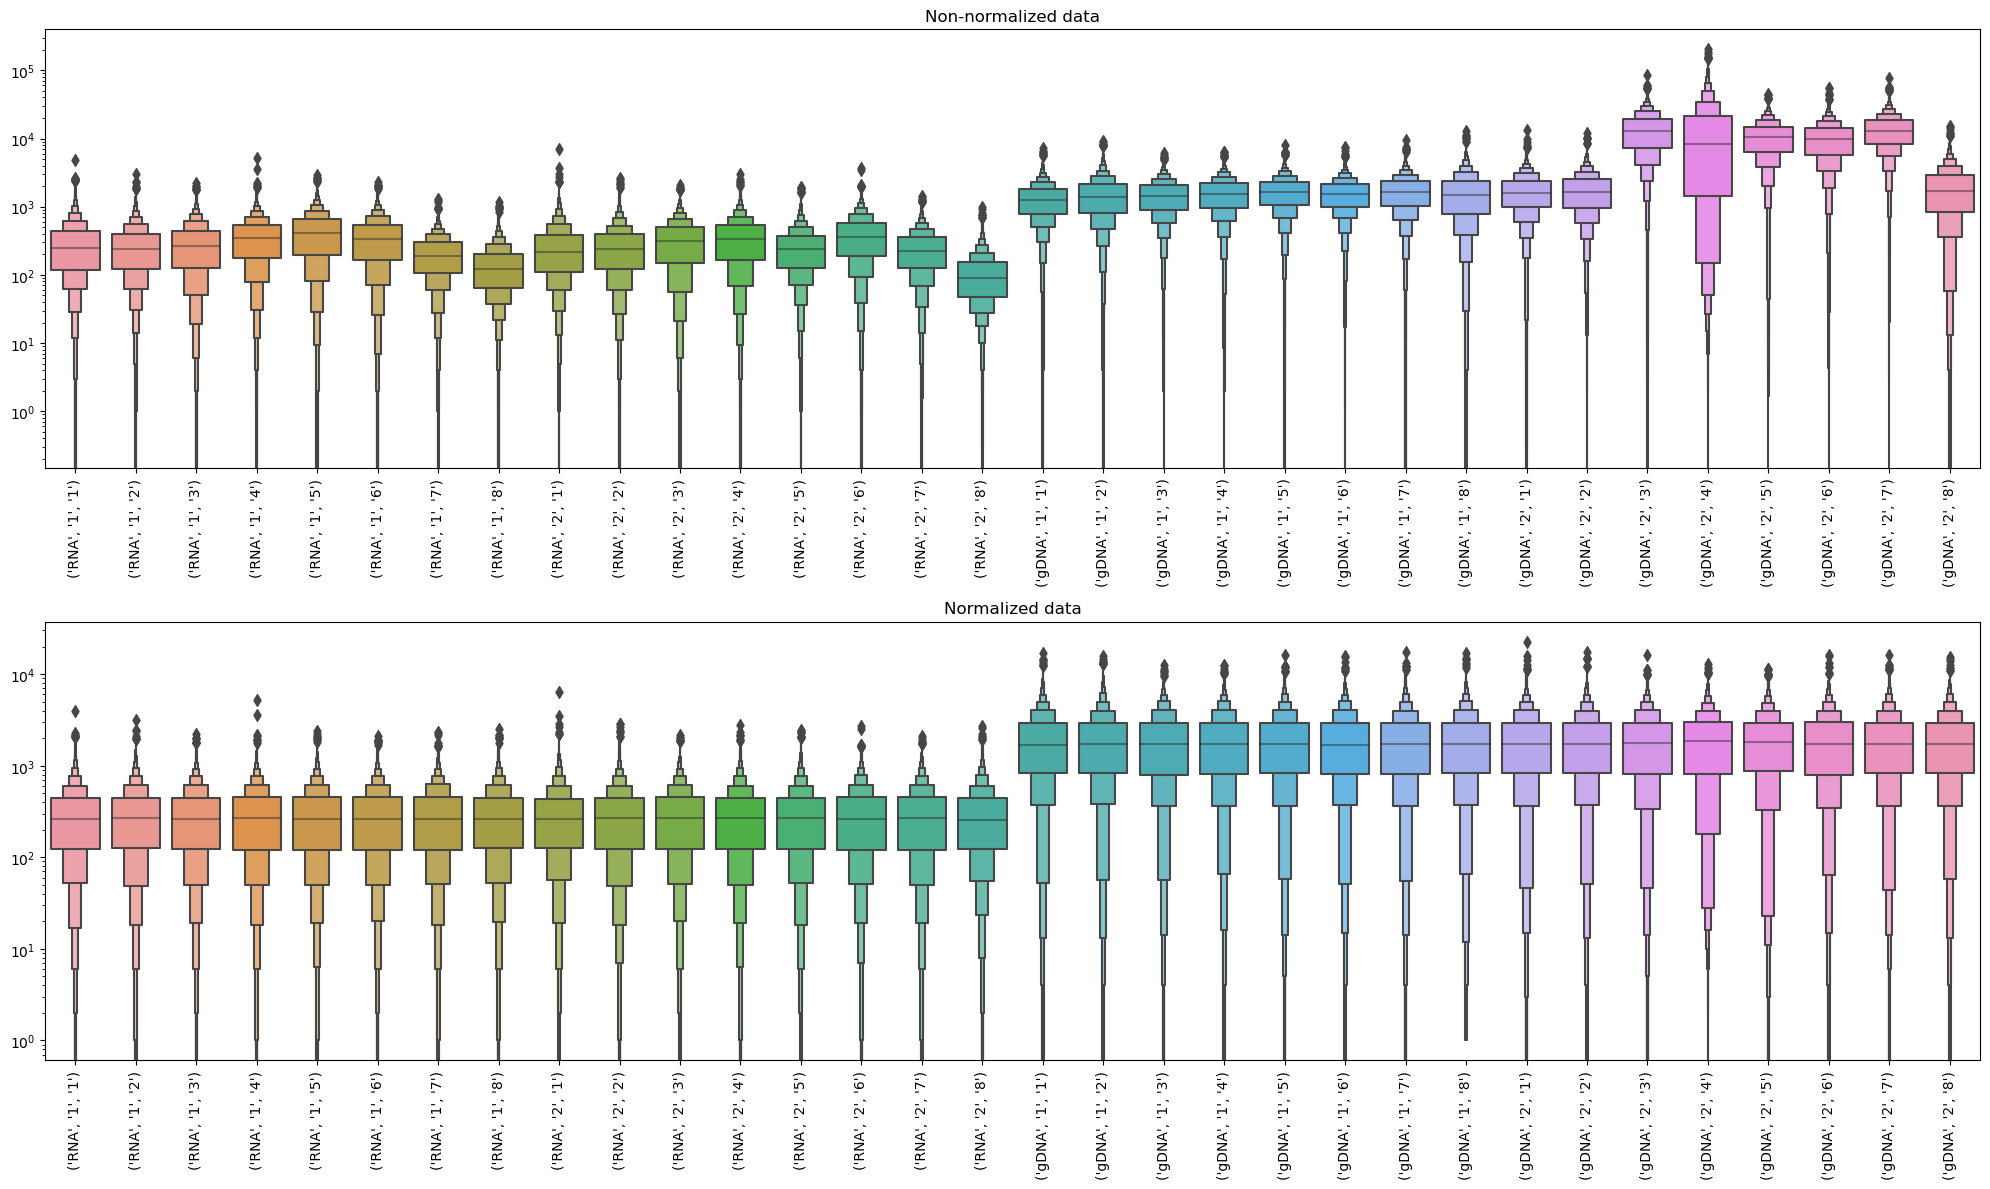

In [20]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 1, 1)
sns.boxenplot(d1)
plt.xticks(rotation=90)
plt.title("Non-normalized data")

plt.yscale("log")

plt.subplot(2, 1, 2)
sns.boxenplot(d1_normalized)
plt.xticks(rotation=90)
plt.title("Normalized data")

plt.yscale("log")

plt.tight_layout()
plt.show()

## Preprocessing

In [21]:
d1_normalized

exp_type                                            RNA                      \
replicate                                             1                       
bin                                                   1    2    3    4    5   
seq                                                                           
ATACGTTAACGCGTATGGGCCTGGGGCCGGTAGAGGCTCCCCAGGGC...  207  306  146  297  307   
ATACGTTAACGCGTATGGGGTGAGGGGGCCCTGAATCAGGGGTGACT...  405  407  264  423  386   
ATACGTTAACGCGTATGGAGGGAAGAAGGGGCCATCACAGGATGCCA...  532  338  392  296  294   
ATACGTTAACGCGTATGGATCTCCCCAGCCCTCCCAGGCCCCATGGG...  271  151  181  269  262   
ATACGTTAACGCGTATGGAAAAGCTGTTTCACTAGAAAAGGCAGAAA...  219  163  207  205  250   
...                                                 ...  ...  ...  ...  ...   
ATACGTTAACGCGTATGGTGGGCTATAGCCAGCCGTTTAAGACTCAA...  538  571  709  396  412   
ATACGTTAACGCGTATGGGGGTATGGGTGTGTGGTTCCACCGCTCCT...  319  498  312  935  347   
ATACGTTAACGCGTATGGGATTTCAGGTCTGTGAACACCTGCACTTC...  734  324  690  747  673   
ATACGTTAACGCGTATGGCTGTGGGCTGGAAAACCACTGGGTGCGTC...  414  668  861  743  904   
ATACGTTAACGCGTATGGCCACTCGTGTTCCTTCAGGGGGTACTGCT...  474  618  455  509  658   

exp_type                                                                      \
replicate                                                             2        
bin                                                   6     7    8    1    2   
seq                                                                            
ATACGTTAACGCGTATGGGCCTGGGGCCGGTAGAGGCTCCCCAGGGC...  307   155  244  311  213   
ATACGTTAACGCGTATGGGGTGAGGGGGCCCTGAATCAGGGGTGACT...  216   489  345  562  412   
ATACGTTAACGCGTATGGAGGGAAGAAGGGGCCATCACAGGATGCCA...  224   234  476  390  274   
ATACGTTAACGCGTATGGATCTCCCCAGCCCTCCCAGGCCCCATGGG...  304   444  584  322  255   
ATACGTTAACGCGTATGGAAAAGCTGTTTCACTAGAAAAGGCAGAAA...  287   345  299  371  203   
...                                                 ...   ...  ...  ...  ...   
ATACGTTAACGCGTATGGTGGGCTATAGCCAGCCGTTTAAGACTCAA...  380   768  293  424  322   
ATACGTTAACGCGTATGGGGGTATGGGTGTGTGGTTCCACCGCTCCT...  733   340  394  595  549   
ATACGTTAACGCGTATGGGATTTCAGGTCTGTGAACACCTGCACTTC...  807   469  329  717  334   
ATACGTTAACGCGTATGGCTGTGGGCTGGAAAACCACTGGGTGCGTC...  528   708  367  387  820   
ATACGTTAACGCGTATGGCCACTCGTGTTCCTTCAGGGGGTACTGCT...  533  1009  451  317  226   

exp_type                                            ...  gDNA              \
replicate                                           ...     1           2   
bin                                                 ...     7     8     1   
seq                                                 ...                     
ATACGTTAACGCGTATGGGCCTGGGGCCGGTAGAGGCTCCCCAGGGC...  ...   843  1409  1442   
ATACGTTAACGCGTATGGGGTGAGGGGGCCCTGAATCAGGGGTGACT...  ...  2915  3092  2388   
ATACGTTAACGCGTATGGAGGGAAGAAGGGGCCATCACAGGATGCCA...  ...  1257   472  2729   
ATACGTTAACGCGTATGGATCTCCCCAGCCCTCCCAGGCCCCATGGG...  ...  2740  3667   780   
ATACGTTAACGCGTATGGAAAAGCTGTTTCACTAGAAAAGGCAGAAA...  ...  2222  1430  1277   
...                                                 ...   ...   ...   ...   
ATACGTTAACGCGTATGGTGGGCTATAGCCAGCCGTTTAAGACTCAA...  ...  2719  2779  5573   
ATACGTTAACGCGTATGGGGGTATGGGTGTGTGGTTCCACCGCTCCT...  ...  8591  8962  5590   
ATACGTTAACGCGTATGGGATTTCAGGTCTGTGAACACCTGCACTTC...  ...  8288  6924  2828   
ATACGTTAACGCGTATGGCTGTGGGCTGGAAAACCACTGGGTGCGTC...  ...  3986  5622  1136   
ATACGTTAACGCGTATGGCCACTCGTGTTCCTTCAGGGGGTACTGCT...  ...   816  1514  1319   

exp_type                                                                    \
replicate                                                                    
bin                                                    2     3     4     5   
seq                                                                          
ATACGTTAACGCGTATGGGCCTGGGGCCGGTAGAGGCTCCCCAGGGC...   930  1093   947  1858   
ATACGTTAACGCGTATGGGGTGAGGGGGCCCTGAATCAGGGGTGACT...  4963  1995  251

In [26]:
seq_id_grouped = drna_meta["seq_id"].str.split("_").str[:3].apply("_".join)
seq_id_grouped

0       ENST00000002829_part_10
1       ENST00000002829_part_10
2        ENST00000002829_part_6
3        ENST00000002829_part_6
4        ENST00000003302_part_3
                 ...           
7494    ENST00000649637_part_15
7495    ENST00000649864_part_16
7496    ENST00000649864_part_16
7497     ENST00000650082_part_6
7498     ENST00000650082_part_6
Name: seq_id, Length: 7499, dtype: object

In [28]:
uniq_ids = seq_id_grouped.drop_duplicates()
uniq_ids

0       ENST00000002829_part_10
2        ENST00000002829_part_6
4        ENST00000003302_part_3
6       ENST00000003583_part_13
8        ENST00000005260_part_8
                 ...           
7489     ENST00000649591_part_8
7491    ENST00000649637_part_11
7493    ENST00000649637_part_15
7495    ENST00000649864_part_16
7497     ENST00000650082_part_6
Name: seq_id, Length: 3750, dtype: object

In [29]:
##################################
#      TRAIN-VAL-TEST SPLIT      #
##################################
# DO NOT CHANGE UNLESS NECESSARY #
##################################
np.random.seed(777)
mark = np.full(fill_value="train", shape=(uniq_ids.shape[0],))
mark[0:mark.shape[0] // 10] = "test"
mark[mark.shape[0] // 10:2 * mark.shape[0] // 10] = "val"
np.random.shuffle(mark)
mark = pd.Series(mark)
mark.index = uniq_ids.values
mark.value_counts()

train    3000
test      375
val       375
Name: count, dtype: int64

In [ ]:
drna_meta["fold"] = seq_id_grouped.map(mark)
drna_meta.head(20)

In [39]:
d1_stacked = d1_normalized.stack(level=[1], dropna=False).reset_index()

In [ ]:
d1_stacked = d1_stacked.set_index(["seq", "replicate"]).stack(level=0).reset_index()
d1_stacked.columns.name = None
d1_stacked

In [42]:
d1_split = d1_stacked.set_index("seq")
d1_split["fold"] = drna_meta.set_index("seq")["fold"]

In [ ]:
d1_split = d1_split[d1_split[["1", "2", "3", "4", "5", "6", "7", "8"]].sum(axis=1) != 0]
d1_split

In [44]:
d1_split.to_csv("../../data/stability/riboswitch_zinb_norm.csv")